Run the following cell only if you are accessing this notebook from google colab

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
filename = 'https://raw.githubusercontent.com/symbiotic-engineering/WEC-DECIDER/rgm-enviro-optim-test/environment.yml?token=GHSAT0AAAAAACGWSPS7WSFPIEUH5GNI5Y5YZOUJB6Q'
!conda env update -n base -f $filename

In [21]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [45]:
steel_slider    = widgets.IntSlider(min=10, max=100, step=10, description='Steel') # eco cost of steel [kg CO2/m3]
distance_slider = widgets.IntSlider(min=10, max=100, step=10, description='Offshore') # eco cost of offshore travel [kg CO2/km]
power_slider    = widgets.IntSlider(min=10, max=100, step=10, description='Power') # eco value of power generated [kg CO2/kW]

display(steel_slider)
display(distance_slider)
display(power_slider)

IntSlider(value=10, description='Steel', min=10, step=10)

IntSlider(value=10, description='Offshore', min=10, step=10)

IntSlider(value=10, description='Power', min=10, step=10)

LCOE:  [0.07293539 0.07293538 0.07293539 0.07293546]
Net eco value:  [0.03447425 0.34490601 1.72597996 3.45759488]


Text(0, 0.5, 'LCOE ($/kWh)')

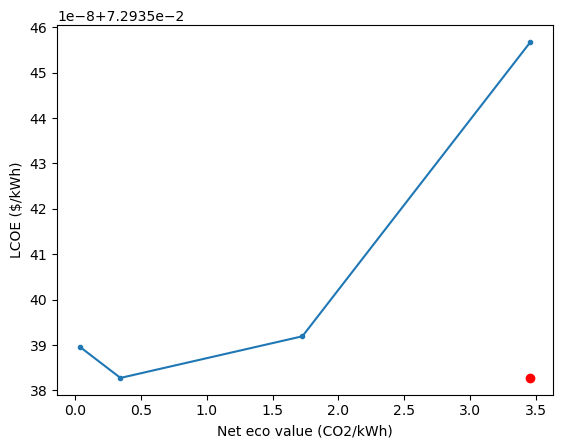

In [50]:
# Extract the values from the widgets
CO2_per_m3_steel = steel_slider.value
CO2_per_km_offshore = distance_slider.value
CO2_avoided_per_kW = power_slider.value

def calc_LCOE_net_eco_value(design_vars):
    CW = design_vars[0]
    distance_from_shore = design_vars[1]

    # power
    wave_power_per_meter = 10000 # W/m
    P_avg = CW * wave_power_per_meter # W
    AEP = P_avg * 8760 / 1000 # kWh

    # capex
    capex_no_steel = 2.5e6
    steel_cost_per_m3 = 3000 # $/m^3
    steel_thickness = 0.025 # m
    height = 4 # m
    steel_volume = (np.pi * (CW/2)**2 + np.pi * CW * height) * steel_thickness
    capex_steel = steel_volume * steel_cost_per_m3
    capex = capex_steel + capex_no_steel

    # LCOE
    opex = 1.2e6
    FCR = 0.113
    LCOE = (capex * FCR + opex) / AEP

    # environmental cost - Leah fill in here
    eco_cost = CO2_per_m3_steel * steel_volume + CO2_per_km_offshore * distance_from_shore
    eco_value = CO2_avoided_per_kW * P_avg / 1000
    net_eco_value = (eco_value - eco_cost) / AEP

    return LCOE, net_eco_value

# wrapper functions to return single values
def calc_LCOE(design_vars):
    LCOE, _ = calc_LCOE_net_eco_value(design_vars)
    return LCOE

def calc_net_eco_value(design_vars):
    _, net_eco_value = calc_LCOE_net_eco_value(design_vars)
    return net_eco_value

# unconstrained optimization
x0 = [0.1, 10]
res_min_LCOE = minimize(calc_LCOE, x0=x0, method='SLSQP',tol=1e-8)

multipliers = np.array([5, 10, 50, 100.0])
LCOEs = np.zeros_like(multipliers)
net_eco_values = np.zeros_like(multipliers)

LCOEs[0], net_eco_values[0] = calc_LCOE_net_eco_value(res_min_LCOE.x)

# repeated constrained optimization
for i in np.arange(len(multipliers)):
    min_net_eco_value = multipliers[i] * net_eco_values[0]
    res = minimize(calc_LCOE, x0=x0, method='SLSQP', constraints={'type': 'ineq', 'fun': lambda x: calc_net_eco_value(x) - min_net_eco_value })
    LCOEs[i], net_eco_values[i] = calc_LCOE_net_eco_value(res.x)

print('LCOE: ',LCOEs)
print('Net eco value: ',net_eco_values)
# plot LCOE vs net_eco_value
plt.plot(net_eco_values, LCOEs, '.-')
plt.plot(max(net_eco_values), min(LCOEs), 'ro')
plt.xlabel('Net eco value (CO2/kWh)')
plt.ylabel('LCOE ($/kWh)')
